In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gradio as gr

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, RocCurveDisplay

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision

from PIL import Image
import os

In [2]:
path ='data/' #set here data directory

In [26]:
def count_files_in_directory(path, labels):
    return len([f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])



In [28]:
labels=['train', 'validation']
count_files_in_directory(path, labels)

['.DS_Store', 'predator', 'alien']
['.DS_Store', 'predator', 'alien']


In [4]:
#TODO Refactor - split for methods
def get_files_size():
    width = []
    height = []
    for direct in os.listdir(path):
        if direct != '.DS_Store': # applicable to MacOS
            for folder in os.listdir(os.path.join(path,direct)):
                if folder != '.DS_Store':
                    for file in os.listdir(os.path.join(path,direct ,folder)):
                        if file != '.DS_Store':
                            width.append(Image.open(os.path.join(path,direct ,folder, file)).size[0])
                            height.append(Image.open(os.path.join(path,direct ,folder, file)).size[0])
    return width, height

In [5]:
#Mean size value from all pictures train+validation
width, height = get_files_size()
width = round(np.array(width).mean())
height =round(np.array(height).mean())
print(f'Dimensions for resize \nwidth: {width}')
print(f'heigth: {height}')

Dimensions for resize 
width: 250
heigth: 250


In [6]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((width,height)), 
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((width,height)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(os.path.join(path,'train'), data_transforms['train']),
    'validation': 
    datasets.ImageFolder(os.path.join(path, 'validation'), data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=128,
                                shuffle=True), 
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=128,
                                shuffle=False)
}

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [8]:
model_resnet18 = models.resnet18(weights=True).to(device)
    
for param in model_resnet18.parameters():
    param.requires_grad = False   
    
model_resnet18.fc = nn.Sequential(
               nn.Linear(512, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
class MultiClassCNN(nn.Module):
    def __init__(self):
        super(MultiClassCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(64*32*32, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # no activation function here as we'll use CrossEntropyLoss which has softmax built-in
        return x
model_MCCNN = MultiClassCNN().to(device)

In [10]:
criterion = nn.CrossEntropyLoss()

## Train

In [11]:
num_epochs = 3

In [12]:
def train_model(model, criterion, optimizer, num_epochs=num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [13]:
%%time
optimizer = optim.Adam(model_resnet18.fc.parameters())
model_resnet18 = train_model(model_resnet18, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/3
----------
train loss: 0.5846, acc: 0.6657
validation loss: 0.4592, acc: 0.8550
Epoch 2/3
----------
train loss: 0.3893, acc: 0.8617
validation loss: 0.3327, acc: 0.8750
Epoch 3/3
----------
train loss: 0.2991, acc: 0.8862
validation loss: 0.2821, acc: 0.9150
CPU times: user 5.23 s, sys: 2.45 s, total: 7.68 s
Wall time: 16.8 s


In [14]:
%%time
optimizer = optim.Adam(model_MCCNN.parameters())
model_MCCNN = train_model(model_MCCNN, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/3
----------
train loss: 0.8604, acc: 0.5115
validation loss: 0.6818, acc: 0.6050
Epoch 2/3
----------
train loss: 0.6868, acc: 0.5159
validation loss: 0.6397, acc: 0.6150
Epoch 3/3
----------
train loss: 0.6496, acc: 0.5908
validation loss: 0.6115, acc: 0.6350
CPU times: user 4.24 s, sys: 1.87 s, total: 6.11 s
Wall time: 7.1 s


## Predict

In [15]:
def plot_predictions(img_list, prediction, title):
    print(title)
    fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
    for i, img in enumerate(img_list):
        ax = axs[i]
        ax.axis('off')
        ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*prediction[i,0],100*prediction[i,1]))
        ax.imshow(img)

In [16]:
def predict(model, img_list, device, transforms):
    model.eval()  # set the model to evaluation mode
    test_batch = torch.stack([transforms(img).to(device) for img in img_list])
    outputs = model(test_batch)
    probs = F.softmax(outputs, dim=1)  # apply softmax to get probabilities
    return probs.cpu().data.numpy()

In [17]:
test_img_paths = ["test/0.jpg",
                        "test/1.jpg",
                        "test/2.jpg",
                         ]
img_list = [Image.open(img_path) for img_path in test_img_paths]

In [18]:
predictions = predict(model_resnet18, img_list, device, data_transforms['validation']) #Using same preprocessing as for validation

ResNet18


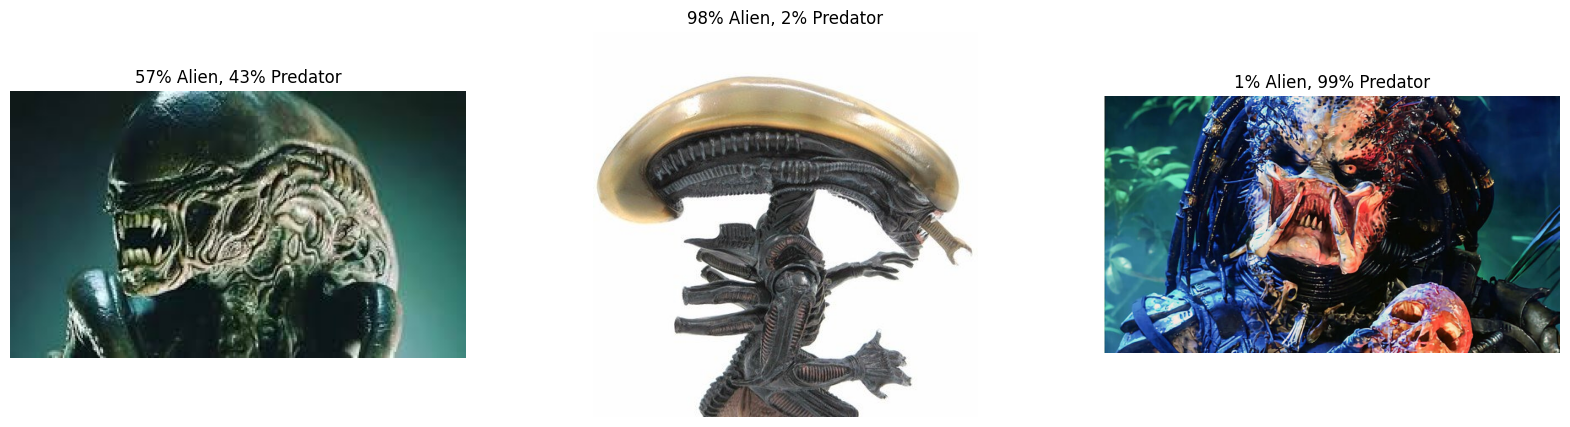

In [19]:
plot_predictions(img_list, predictions, "ResNet18")

In [20]:
predictions = predict(model_MCCNN, img_list, device, data_transforms['validation']) #Using same preprocessing as for validation

MultiClassCNN


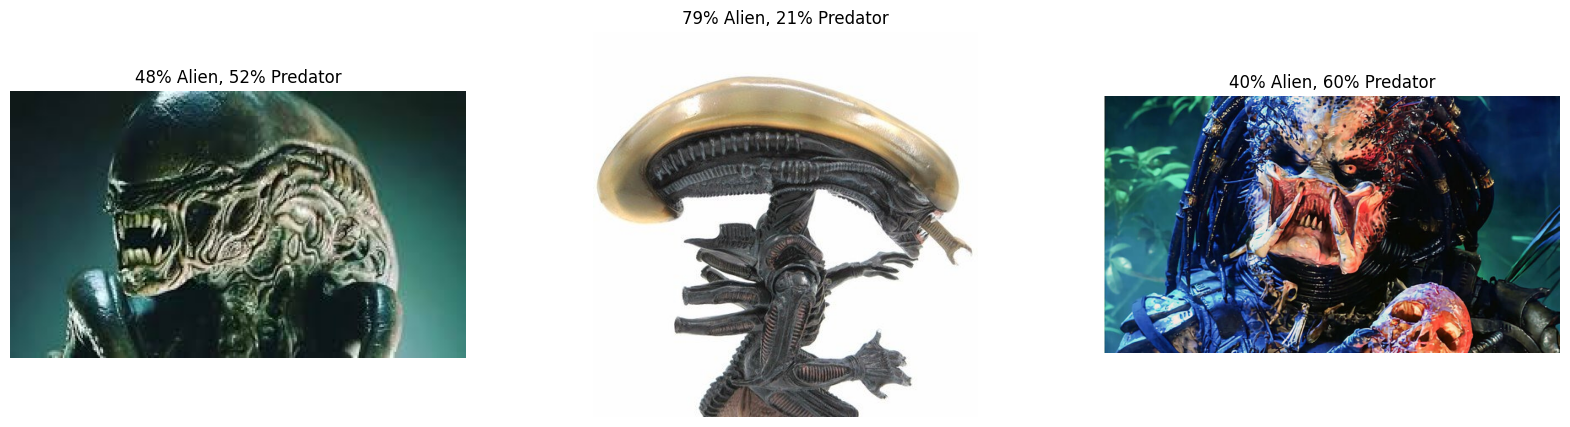

In [21]:
plot_predictions(img_list, predictions, "MultiClassCNN")

## Comapre

In [22]:
def compare_models(model1, model2, dataloader):
    model1.eval()
    model2.eval()

    correct_model1 = 0
    correct_model2 = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs1 = model1(images)
            _, predicted1 = torch.max(outputs1.data, 1)

            outputs2 = model2(images)
            _, predicted2 = torch.max(outputs2.data, 1)

            total += labels.size(0)
            
            correct_model1 += (predicted1 == labels).sum().item()
            correct_model2 += (predicted2 == labels).sum().item()

    accuracy_model1 = correct_model1 / total
    accuracy_model2 = correct_model2 / total

    return accuracy_model1, accuracy_model2

In [23]:
compare_models(model_resnet18, model_MCCNN, dataloaders['validation'])

(0.915, 0.635)

## Gradio

In [24]:
best_model = model_resnet18

def predict_image(image):
    class_names=['Alien', 'Predator']
    
    image = Image.fromarray(image)
    image = data_transforms['validation'](image).unsqueeze(0).to(device)   
    output = best_model(image)    
    probabilities = F.softmax(output, dim=1).detach().cpu().numpy().flatten()
    
    return {class_name: float(probability) for class_name, probability in zip(class_names, probabilities)}


iface = gr.Interface(
    fn=predict_image, 
    inputs=gr.inputs.Image(shape=(width, height)), 
    outputs="label",
)

iface.launch()


/opt/miniconda3/envs/torch/lib/python3.9/site-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
